In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
prob = 0.5
dropout = nn.Dropout(p=prob)
x = torch.ones(10)

y = dropout(x)

print(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 2., 2., 2., 0., 2., 2., 0., 2.])
tensor(1.4000)


Dropout is turned off during evaluation

In [3]:
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


Unexpectedly, turning our model's eval mode on does not affect the dropout function in the functional module

In [4]:
dropout.eval()
y = F.dropout(x)
print(y)

tensor([0., 2., 2., 2., 0., 0., 0., 0., 0., 2.])


But we can turn it on by setting the `training` parameter to **False**

In [5]:
y = F.dropout(x, training=False)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


Below cell proves that you have to remember to turn training mode on to turn on dropout

In [6]:
dropout.train()
y = dropout(x)
print(y)

dropout.eval()
y = dropout(x)
print(y)

y = dropout(x)
print(y)

tensor([0., 2., 0., 2., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


# Regularization in practice
## Create the data

In [7]:
n_per_cluster = 200

theta = np.linspace(0, 4 * np.pi, n_per_cluster)
r1 = 10
r2 = 15

a = np.array(
    [
        r1 * np.cos(theta) + np.random.rand(n_per_cluster) * 3,
        r1 * np.sin(theta) + np.random.rand(n_per_cluster),
    ]
)
b = np.array(
    [
        r2 * np.cos(theta) + np.random.rand(n_per_cluster),
        r2 * np.sin(theta) + np.random.rand(n_per_cluster) * 3,
    ]
)
print(f"Shape of a: {a.shape}, shape of b: {b.shape}")

labels = np.vstack((np.zeros((n_per_cluster, 1)), np.ones((n_per_cluster, 1))))
print(f"Shape of labels: {labels.shape}")

data_matrix = np.hstack((a, b)).transpose()
print(f"Shape of data matrix: {data_matrix.shape}")

data_tensor = torch.tensor(data_matrix).float()
labels_tensor = torch.tensor(labels).float()

Shape of a: (2, 200), shape of b: (2, 200)
Shape of labels: (400, 1)
Shape of data matrix: (400, 2)


In [8]:
labels

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [9]:
data_tensor.shape

torch.Size([400, 2])

In [10]:
np.where(labels == 1)

(array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
        304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
        317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
        330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
        343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
        356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
        369, 370, 371, 372, 373, 374, 375, 376, 377

In [11]:
data_tensor[(np.arange(200), np.zeros(200))]

tensor([11.6532, 12.2069, 11.5557, 10.8429, 12.1026, 10.6200, 12.0631, 11.7593,
        11.2240, 10.3201,  9.4582,  9.0898,  8.2482,  8.9220,  7.2204,  7.5962,
         7.5240,  6.5565,  5.6890,  4.2693,  5.2332,  5.3796,  4.5194,  3.0969,
         3.3644,  2.0748,  1.0572,  0.7522, -0.5686,  0.3258, -2.2221, -3.3719,
        -2.8735, -2.0345, -4.2288, -5.1203, -5.1625, -5.9980, -6.0404, -5.4979,
        -5.2994, -6.8708, -8.7981, -6.7626, -7.8127, -8.6724, -8.5356, -8.1756,
        -7.0927, -8.0323, -8.3965, -7.3596, -7.5474, -8.3942, -9.2984, -7.8080,
        -7.4838, -7.4609, -5.9614, -6.3167, -6.4090, -6.4231, -6.3208, -6.1255,
        -5.8970, -4.8022, -4.7377, -1.8752, -2.5241, -1.0603, -0.7986,  0.0941,
         0.7860,  1.0259, -0.3508,  2.4579,  3.5328,  2.6166,  4.8138,  2.9953,
         4.7673,  5.9468,  4.7326,  6.9392,  6.6327,  6.9746,  7.2072,  7.9163,
         7.7297, 10.0767,  8.4963,  8.7944, 11.1780, 11.7248, 10.3469, 10.6487,
        12.1440, 12.3368, 11.6493, 11.06

In [12]:
data_tensor[np.where(labels == 0)]

tensor([11.6532, 12.2069, 11.5557, 10.8429, 12.1026, 10.6200, 12.0631, 11.7593,
        11.2240, 10.3201,  9.4582,  9.0898,  8.2482,  8.9220,  7.2204,  7.5962,
         7.5240,  6.5565,  5.6890,  4.2693,  5.2332,  5.3796,  4.5194,  3.0969,
         3.3644,  2.0748,  1.0572,  0.7522, -0.5686,  0.3258, -2.2221, -3.3719,
        -2.8735, -2.0345, -4.2288, -5.1203, -5.1625, -5.9980, -6.0404, -5.4979,
        -5.2994, -6.8708, -8.7981, -6.7626, -7.8127, -8.6724, -8.5356, -8.1756,
        -7.0927, -8.0323, -8.3965, -7.3596, -7.5474, -8.3942, -9.2984, -7.8080,
        -7.4838, -7.4609, -5.9614, -6.3167, -6.4090, -6.4231, -6.3208, -6.1255,
        -5.8970, -4.8022, -4.7377, -1.8752, -2.5241, -1.0603, -0.7986,  0.0941,
         0.7860,  1.0259, -0.3508,  2.4579,  3.5328,  2.6166,  4.8138,  2.9953,
         4.7673,  5.9468,  4.7326,  6.9392,  6.6327,  6.9746,  7.2072,  7.9163,
         7.7297, 10.0767,  8.4963,  8.7944, 11.1780, 11.7248, 10.3469, 10.6487,
        12.1440, 12.3368, 11.6493, 11.06

In [13]:
data_tensor[np.where(labels == 0)[0], 0]

tensor([11.6532, 12.2069, 11.5557, 10.8429, 12.1026, 10.6200, 12.0631, 11.7593,
        11.2240, 10.3201,  9.4582,  9.0898,  8.2482,  8.9220,  7.2204,  7.5962,
         7.5240,  6.5565,  5.6890,  4.2693,  5.2332,  5.3796,  4.5194,  3.0969,
         3.3644,  2.0748,  1.0572,  0.7522, -0.5686,  0.3258, -2.2221, -3.3719,
        -2.8735, -2.0345, -4.2288, -5.1203, -5.1625, -5.9980, -6.0404, -5.4979,
        -5.2994, -6.8708, -8.7981, -6.7626, -7.8127, -8.6724, -8.5356, -8.1756,
        -7.0927, -8.0323, -8.3965, -7.3596, -7.5474, -8.3942, -9.2984, -7.8080,
        -7.4838, -7.4609, -5.9614, -6.3167, -6.4090, -6.4231, -6.3208, -6.1255,
        -5.8970, -4.8022, -4.7377, -1.8752, -2.5241, -1.0603, -0.7986,  0.0941,
         0.7860,  1.0259, -0.3508,  2.4579,  3.5328,  2.6166,  4.8138,  2.9953,
         4.7673,  5.9468,  4.7326,  6.9392,  6.6327,  6.9746,  7.2072,  7.9163,
         7.7297, 10.0767,  8.4963,  8.7944, 11.1780, 11.7248, 10.3469, 10.6487,
        12.1440, 12.3368, 11.6493, 11.06

In [14]:
example_tensor = torch.tensor([[2, 4], [6, 8], [10, 12], [14, 16]])
example_tensor

tensor([[ 2,  4],
        [ 6,  8],
        [10, 12],
        [14, 16]])

In [15]:
example_tensor.shape

torch.Size([4, 2])

In [16]:
example_tensor[(0, 1, 2, 3), 0]

tensor([ 2,  6, 10, 14])

In [17]:
example_array = np.array([[0, 1], [2, 3], [0, 4]])
example_array

array([[0, 1],
       [2, 3],
       [0, 4]])

In [18]:
np.where(example_array == 0)

(array([0, 2]), array([0, 0]))

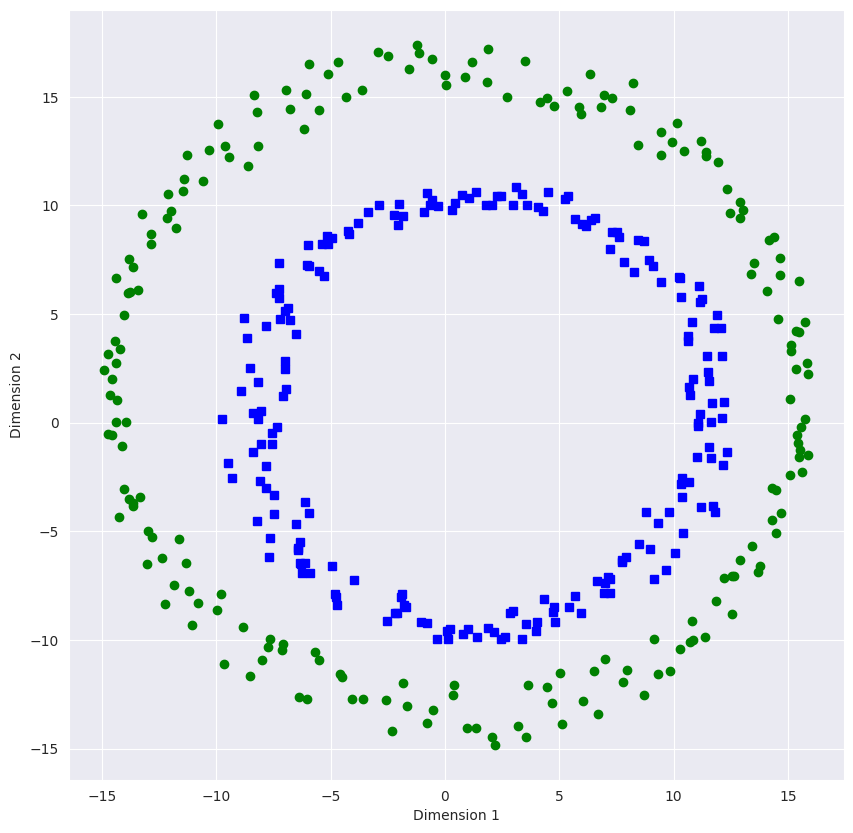

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(
    data_tensor[np.where(labels == 0)[0], 0],
    data_tensor[np.where(labels == 0)[0], 1],
    "bs",
)
ax.plot(
    data_tensor[np.where(labels == 1)[0], 0],
    data_tensor[np.where(labels == 1)[0], 1],
    "go",
)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

plt.show()

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_tensor, labels_tensor, test_size=0.2
)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [21]:
class TheModel(nn.Module):
    def __init__(self, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        self.dr = dropout_rate

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)
        return x

In [22]:
tmpnet = TheModel(0.25)
tmpdata = torch.randn(10, 2)
tmpoutput = tmpnet(tmpdata)
tmpoutput

tensor([[ 0.0021],
        [ 0.0365],
        [ 0.1623],
        [-0.0554],
        [-0.0935],
        [-0.2083],
        [-0.1049],
        [-0.2465],
        [-0.0167],
        [ 0.0172]], grad_fn=<AddmmBackward0>)

## Functions to create and train the net

In [23]:
ann_clf = TheModel(0)
optimizer = torch.optim.SGD(params=ann_clf.parameters(), lr=0.002)
loss_fn = nn.BCEWithLogitsLoss()

In [24]:
def train_the_model(model, loss_func, optim_func, epochs):
    train_acc = np.array([])
    test_acc = np.array([])

    for epi in range(epochs):
        batch_acc = np.array([])

        model.train()
        for X, y in train_loader:
            y_hat = model(X)

            loss = loss_func(y_hat, y)

            optim_func.zero_grad()
            loss.backward()
            optim_func.step()

            batch_acc = np.append(
                batch_acc, 100 * torch.mean(((y_hat > 0.5) == y).float()).item()
            )

        train_acc = np.append(train_acc, np.mean(batch_acc))

        model.eval()
        with torch.inference_mode():
            X, y = next(iter(test_loader))
            y_hat_test = model(X)
            test_acc = np.append(
                test_acc, 100 * torch.mean(((y_hat_test > 0.5) == y).float()).item()
            )

    return train_acc, test_acc

In [25]:
train_acc, test_acc = train_the_model(ann_clf, loss_fn, optimizer, 1000)

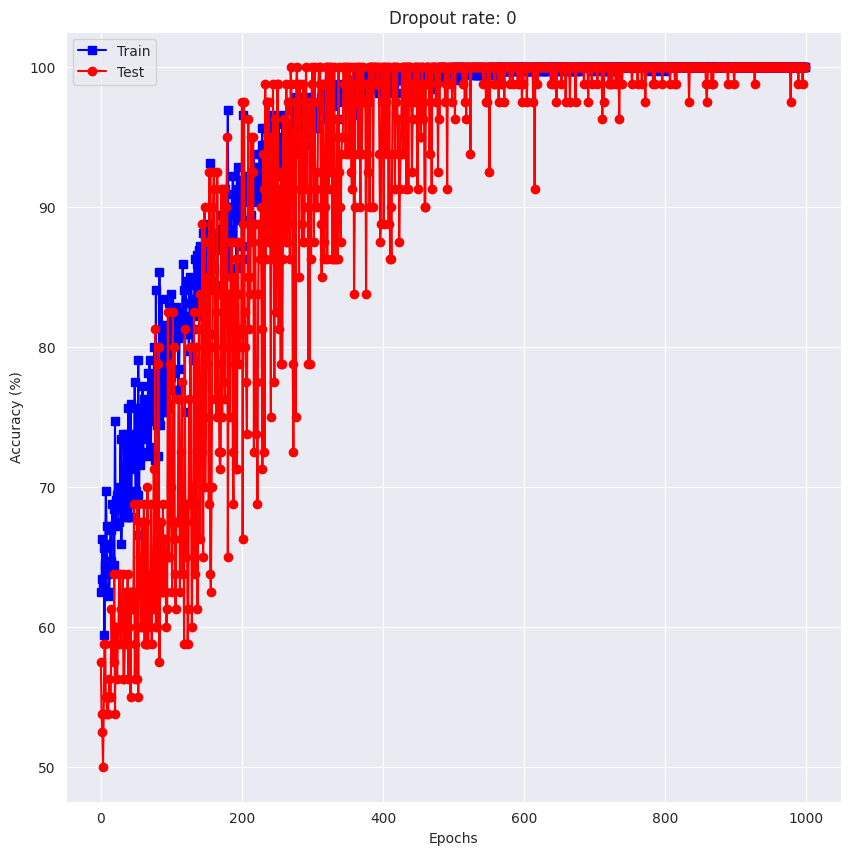

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(train_acc, "bs-", label="Train")
ax.plot(test_acc, "ro-", label="Test")

ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epochs")
ax.set_title(f"Dropout rate: {0}")
ax.legend()

plt.show()

# L2 regularization

In [27]:
iris = sns.load_dataset("iris")

data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(iris), dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, train_size=0.8
)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))


def create_a_new_penalized_model(l2_lambda):
    model = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=l2_lambda)

    return model, loss_fn, optimizer


def train_the_model(
    model, loss_func, optim_func, epochs
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    train_acc = np.array([])
    test_acc = np.array([])
    losses = np.array([])

    for epi in range(epochs):
        batch_acc = np.array([])
        batch_loss = np.array([])

        model.train()
        for X, y in train_loader:
            y_hat = model(X)

            loss = loss_func(y_hat, y)

            optim_func.zero_grad()
            loss.backward()
            optim_func.step()

            batch_acc = np.append(
                batch_acc,
                100 * torch.mean((torch.argmax(y_hat, dim=1) == y).float()).item(),
            )
            batch_loss = np.append(batch_loss, loss.item())

        train_acc = np.append(train_acc, np.mean(batch_acc))
        losses = np.append(losses, np.mean(batch_loss))

        model.eval()
        with torch.inference_mode():
            X, y = next(iter(test_loader))
            y_hat_test = model(X)
            test_acc = np.append(
                test_acc,
                100 * torch.mean((torch.argmax(y_hat_test, dim=1) == y).float()).item(),
            )

    return train_acc, test_acc, losses

In [28]:
l2_lambda = 0.01
ann_iris, loss_fn, optimizer = create_a_new_penalized_model(l2_lambda)
train_acc, test_acc, losses = train_the_model(ann_iris, loss_fn, optimizer, epochs=1000)

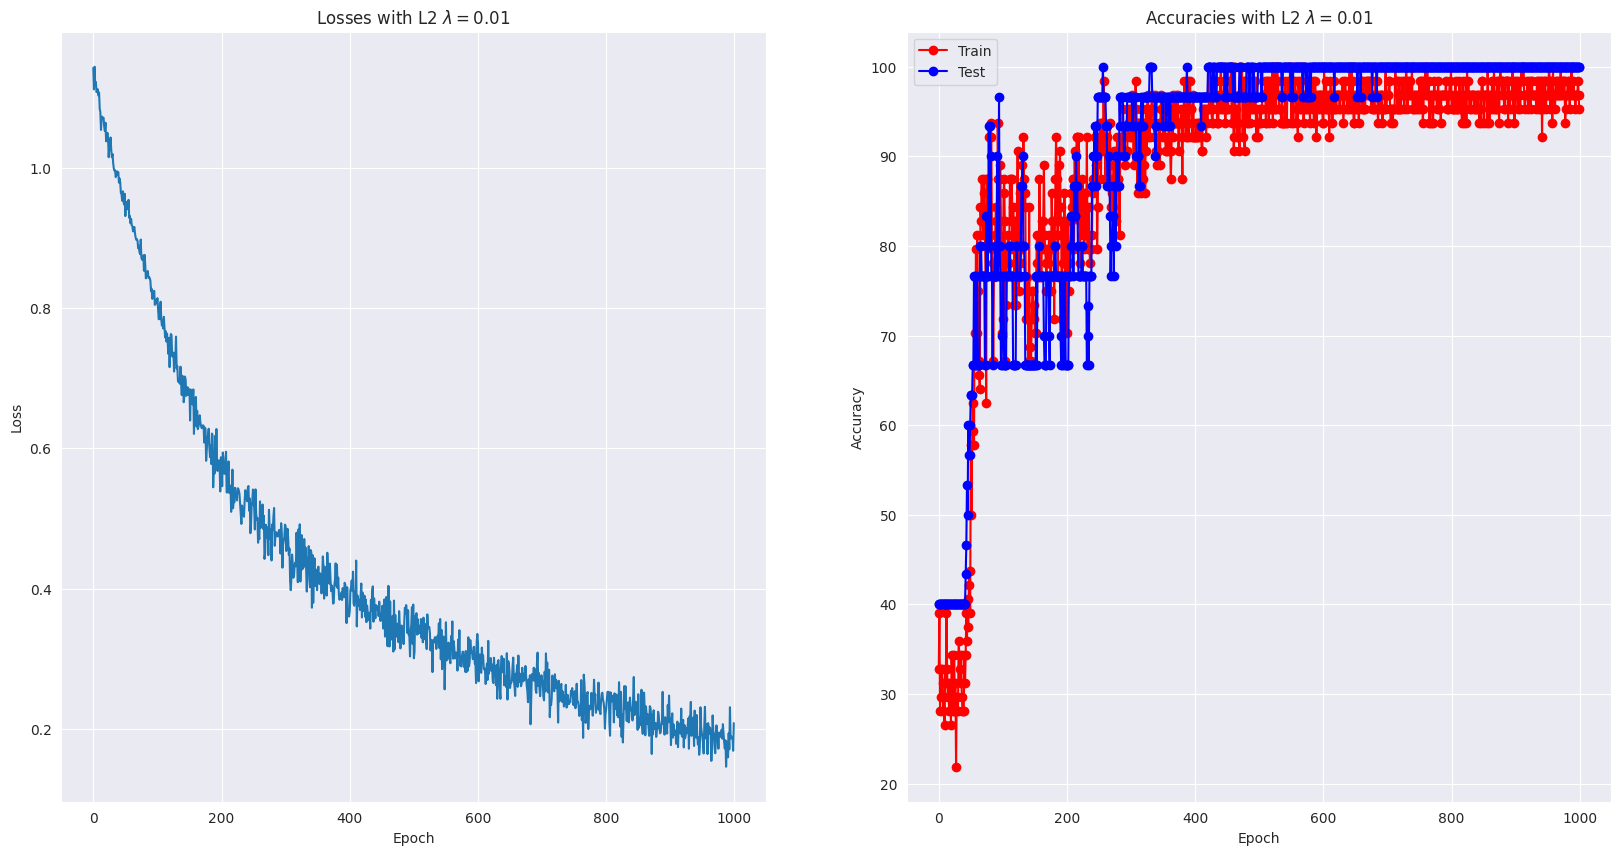

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.plot(losses)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title(f"Losses with L2 $\lambda=${l2_lambda}")

ax2.plot(train_acc, "ro-", label="Train")
ax2.plot(test_acc, "bo-", label="Test")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title(f"Accuracies with L2 $\lambda=${l2_lambda}")
ax2.legend()

plt.show()

## Experiment

In [30]:
n_epochs = 1000
l2_lambda_range = np.linspace(0, 0.1, 10)

train_acc_res = np.zeros((n_epochs, len(l2_lambda_range)))
test_acc_res = np.zeros((n_epochs, len(l2_lambda_range)))

for li in range(len(l2_lambda_range)):
    ann_iris, loss_fn, optimizer = create_a_new_penalized_model(l2_lambda_range[li])
    train_acc, test_acc, _ = train_the_model(ann_iris, loss_fn, optimizer, n_epochs)

    train_acc_res[:, li] = train_acc
    test_acc_res[:, li] = test_acc

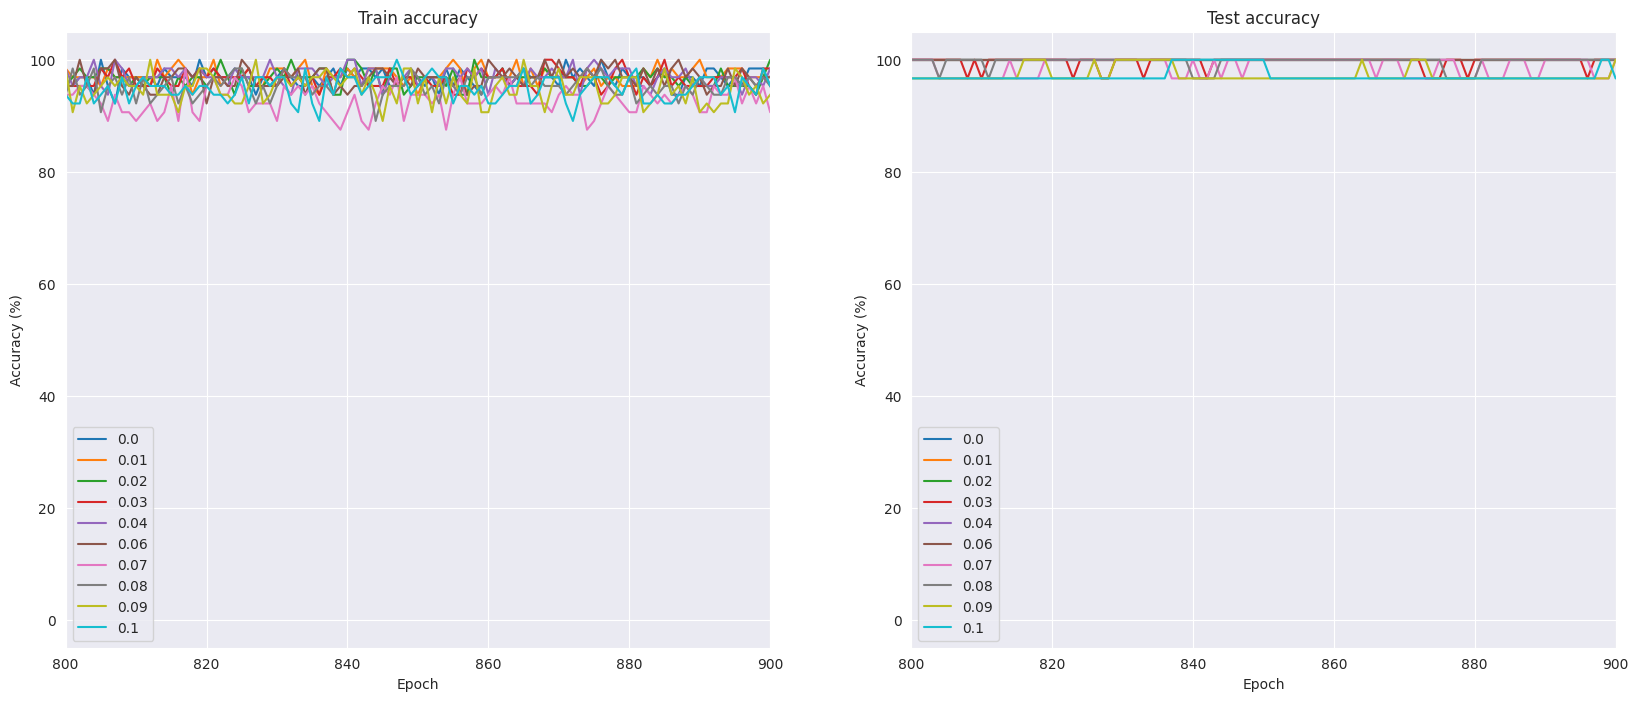

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax[0].plot(train_acc_res)
ax[1].plot(test_acc_res)
ax[0].set_title("Train accuracy")
ax[1].set_title("Test accuracy")

line_labels = [np.round(li, 2) for li in l2_lambda_range]

for i in range(len(ax)):
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_xlim([800, 900])
    ax[i].legend(line_labels)
    ax[i].grid(True)

plt.show()